# M6_AI3: Reconocimiento de números escritos a mano
#### Autor: Leandro Gutierrez
#### Este documento intenta dar respuesta a la actividad 2 propuesta en el Modulo **Técnicas de Machine Learning** del **Master en Big Data y Ciencia de Datos**. En él se describirán cada uno de los enunciados postulados y los resultados obtenidos utilizando Python y Google Colab.
#### Noviembre 18, 2024

# Enunciado
### Contexto
La base de datos MNIST (base de datos modificada del Instituto Nacional de Estándares y Tecnología) es una gran base de datos de dígitos escritos a mano que se usa, comúnmente, para entrenar varios sistemas de procesamiento de imágenes. La base de datos MNIST contiene 60.000 imágenes de entrenamiento y 10.000 imágenes de prueba.

Disponemos de la siguiente información:

- X_train: array de 60.000x28x28, donde cada celda representa un pixel de las diferentes imágenes. Es decir, que tenemos un set de entrenamiento de 60.000 dígitos de 28x28 píxeles (784 pixels) cada uno. Los valores de cada celda representan el código RGB en escala de grises de los diferentes píxeles (0 es blanco y 255 es negro). 
- Y_train: array de 60.000 filas, donde cada fila tiene el valor entero del dígito de la imagen. 
- X_test: array de 10.000x28x28, donde cada celda representa un pixel de las diferentes imágenes. Es decir, que tenemos un set de test de 10.000 dígitos de 28x28 píxeles (784 pixels) cada uno. Los valores de cada celda representan el código RGB en escala de grises de los diferentes píxeles (0 es blanco y 255 es negro). 
- Y_test: array de 10.000 filas, donde cada fila tiene el valor entero del dígito de la imagen.

Con estos datos, debes generar un modelo con el algoritmo de Random Forest que pueda encontrar patrones de reconocimiento de imágenes.
Se pide seguir lo expuesto en la guía de uso de la librería Scikit-Learn.
En dicha página, se lleva a cabo usando el dataset de MNIST de la librería Scikit-Learn y aplicando el algoritmo de Support Vector Machine (SVM).
Deberás hacer los cambios que procedan para usar el dataset de TensorFlow (que es más extenso y con más resolución) y cambiar SVM por Random Forest.

Con todos estos datos te pedimos lo siguiente:
1. Lectura del dataset desde TensorFlow. 
2. Aplicar las conversiones necesarias para pasar de 3d-array a 2d-array (con “reshape”). 
3. Crear la variable “n_train” para poder generar diferentes modelos. 
4. Generar un modelo con cada uno de los siguientes valores: 
   - n_train = 600. 
   - n_train = 6000. 
5. Realizar diferentes modelos cambiando los valores de n_estimators y max_depth. 
6. Comentar los resultados de los diferentes modelos. 

# Solución

## Carga de los datos

In [179]:
# importamos las librerias
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

Importamos los datos mediante la librería `Tensorflow`

In [1]:
# cargamos los datos desde tensorflow
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Exploramos las dimensiones de lo conjuntos de test y entrenamiento

In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Vemos que contamos con **60000** observaciones en nuestra partición de `entrenamiento` y **10000** en la de `testeo`. 

A su vez notamos que cada muestra es, en sí misma, una matriz de 28x28 registros, donde cada celda representa un pixel de la imagen. Como menciona el enunciado cada celda lleva un valor entero entre 0 y 255, y representa el color de cada pixel en escalas de grises.

Visualicemos las imagenes con las que trabajaremos para darnos una mejor idea de nuestro dataset de entrada

<class 'numpy.ndarray'>


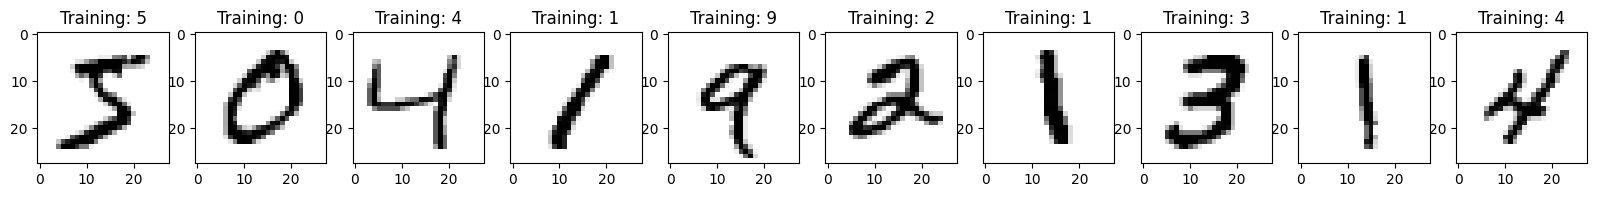

In [25]:
import matplotlib.pyplot as plt

class_names = ['0', '1', '2', '3', '4', '5',
               '6', '7', '8', '9']

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 6))

print(type(axes))
for ax, image, label in zip(axes, x_train, y_train):
    #ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %s" % class_names[label])

Veamos la distribución de cada número (clase) en nuestra partición de entrenamiento

In [37]:
unique, counts = np.unique(y_train, return_counts=True)

print(np.asarray((class_names, counts)).T)

[['0' '5923']
 ['1' '6742']
 ['2' '5958']
 ['3' '6131']
 ['4' '5842']
 ['5' '5421']
 ['6' '5918']
 ['7' '6265']
 ['8' '5851']
 ['9' '5949']]


Hacemos lo mismo ahora para los datos de testeo

In [38]:
unique, counts = np.unique(y_test, return_counts=True)

print(np.asarray((class_names, counts)).T)

[['0' '980']
 ['1' '1135']
 ['2' '1032']
 ['3' '1010']
 ['4' '982']
 ['5' '892']
 ['6' '958']
 ['7' '1028']
 ['8' '974']
 ['9' '1009']]


Notamos que las clases, es decir los diferentes números representados por las imagenes que tenemos, están bien balanceadas tanto en el set de entrenamiento como en el de testeo. Esto nos indica que la métrica `accuracy` será representativa de la calidad de nuestro modelo.

## Preparación

Necesitamos adaptar los datos con los que contamos para que el algortimo de Random Forest pueda interpretarlos, esto implica hacer un `aplanamiento` de nuestras imagenes las cuales se encuentran reprentadas en una matriz de 2 dimensiones de 28x28. Utilizaremos la función `reshape` para ello

In [52]:
x_train_r = x_train.reshape(len(x_train),-1)
x_test_r = x_test.reshape(len(x_test),-1)

print(x_train_r.shape)
print(x_test_r.shape)

(60000, 784)
(10000, 784)


## Experimentación con diferentes tamaños de muestreos

Para analizar como influye la cantidad de datos que utilizamos en entrenamiento realizaremos un proceso `iterativo` para crear diferentes modelos con diferentes basados en diferentes sets de entrenamiento y analizaremos visualmente luego el `accuracy` de cada uno de ellos.

Analizaremos modelos que fueron entrenados con 600, 6000, 30000 y 60000 muestras de entrenamiento respectivamente. Además es importante destacar que mantendremos los parametros (`max_depth`, `n_estimators`) de creación del modelo fijos entre las iteraciónes

In [176]:
n_list = [600, 6000, 30000, 60000]
score_train_list = []
score_test_list = []
mse_train_list = []
mse_test_list = []

max_depth = 4
n_estimators = 10
n_jobs = 5

# iteramos creando modelos de random forest con diferentes max_depth
for n_train in n_list:
    x_train_n = x_train_r[0:n_train]
    y_train_n = y_train[0:n_train]

    rf_model = RandomForestClassifier(max_depth=max_depth, random_state=0, n_jobs=n_jobs, n_estimators=n_estimators)
    rf_model.fit(x_train_n, y_train_n)

    pred_train = rf_model.predict(x_train_n)
    pred_test = rf_model.predict(x_test_r)

    score_train_list.append(100.0*rf_model.score(x_train_n, y_train_n))
    score_test_list.append(100.0*rf_model.score(x_test_r, y_test))

    mse_train_list.append(mean_squared_error(y_train_n, pred_train))
    mse_test_list.append(mean_squared_error(y_test, pred_test))

rs = pd.DataFrame({"n_train":n_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list,
                   "mse_train":mse_train_list,
                   "mse_test":mse_test_list})

Veamos los resultados obtenidos de manera tabular

In [177]:
rs = rs.set_index("n_train")
rs

,score_train,score_test,mse_train,mse_test
n_train,,,,
600,82.333333,69.88,3.611667,5.1240
6000,76.433333,73.01,3.796000,4.3614
30000,74.813333,75.71,4.341100,3.9955
60000,73.883333,73.91,4.126617,3.9443


Ahora veamos gráficamente que sucede con los scores (`accuracy`) de cada uno de los modelos creados

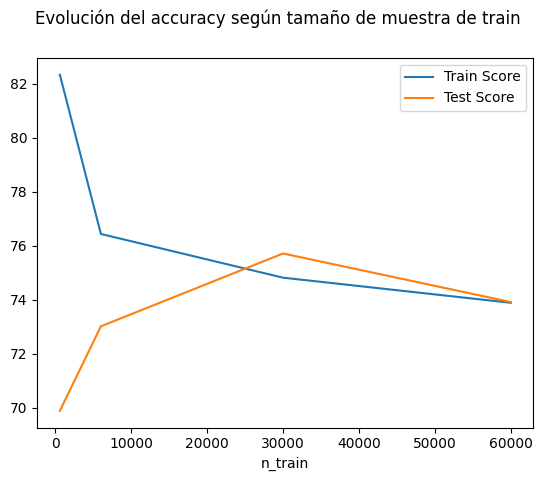

In [178]:
# visualizamos las curvas de score
rs["score_train"].plot(label="Train Score")
rs["score_test"].plot(label="Test Score")
plt.suptitle("Evolución del accuracy según tamaño de muestra de train")
plt.legend()
plt.show()

Podemos observar el desempeño de los diferentes modelos entrenados, donde cada uno tuvo una cantidad diferente de elementos en su partición de entrenamiento.

En un principio para el modelo donde el muestreo de entrenamiento solo tenía 600 observaciones, la diferencia en la performance de entrenamiento y la de testeo rondaba los **0.12**.

Se percibe que al crecer el numero de muestras en la partición de entrenamiento el scoring de `train` y `test` parecen converger a valores similares, al rededor de los **0.75**.

## Experimentación con diferentes los diferentes parámetros

Podemos realizar un análisis similar al anterior para identificar como afecta la variación de los parámetros `max_depth` y `n_estimators`

### max_depth

Primero analizaremos el impacto del parametro `max_depth` en nuestro modelo, tengamos en cuenta aquí que estaremos utilizando el total de datos de training que nos proveyó `tensorflow` en un comienzo, es decir las 60000 observaciones, y tendremos fijo el numero de estimadores en **10**

In [160]:
score_train_list = []
score_test_list = []
mse_train_list = []
mse_test_list = []

max_depth_list = []
min = 1
max = 30
hop = 5

n_estimators = 10
n_jobs = 5

# iteramos creando modelos de random forest clasificadores con diferentes tamaños de entrenamiento
for max_depth in list(range(min,max,hop)):
    rf_model = RandomForestClassifier(max_depth=max_depth, random_state=0, n_jobs=n_jobs, n_estimators=n_estimators)
    rf_model.fit(x_train_r, y_train)

    max_depth_list.append(max_depth)

    pred_train = rf_model.predict(x_train_r)
    pred_test = rf_model.predict(x_test_r)

    score_train_list.append(100.0*rf_model.score(x_train_r, y_train))
    score_test_list.append(100.0*rf_model.score(x_test_r, y_test))

    mse_train_list.append(mean_squared_error(y_train, pred_train))
    mse_test_list.append(mean_squared_error(y_test, pred_test))

rs = pd.DataFrame({"max_depth":max_depth_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list,
                   "mse_train":mse_train_list,
                   "mse_test":mse_test_list})

In [148]:
rs

,max_depth,score_train,score_test,mse_train,mse_test
0,1,45.366667,46.33,9.969400,9.3998
1,6,85.078333,85.89,2.513100,2.3772
2,11,96.270000,93.74,0.656367,1.0811
3,16,99.546667,94.75,0.098067,0.9754
4,21,99.806667,94.52,0.039750,0.9571
5,26,99.895000,94.85,0.021467,0.9269


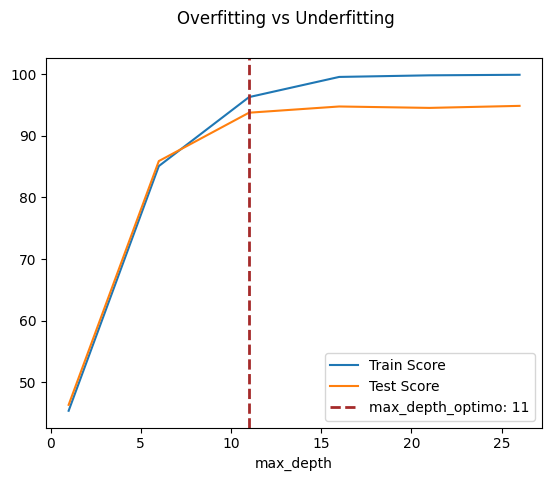

In [161]:
rs = rs.set_index("max_depth")
# visualizamos las curvas de score
rs["score_train"].plot(label="Train Score")
rs["score_test"].plot(label="Test Score")
plt.suptitle("Evolución del accuracy según `max_depth`")
plt.axvline(11, color='brown', linestyle='dashed', linewidth=2, label='max_depth_optimo: 11')
plt.legend()
plt.show()


Se puede apreciar a simple vista como crece paulatinamente la precisión del modelo al aumentar la profundidad máxima de los arboles que lo conforman. Necesitamos encontrar en este punto el máximo valor posible de `accuracy` para nuestra muestra de test, mientras mantiene la mímina distancia con la performance de la partición de entrenamiento, podemos encontrar dicho posición de balance al rededor de los 11, es decir esta será la profundidad óptima para nuestros árboles interiores.

### n_estimators

Veamos ahora que sucede cuando mantenemos fijo la cantidad de datos de entrenamiento y la profundidad máxima, mientras variamos la cantidad de árboles que conforman el modelo

In [168]:
score_train_list = []
score_test_list = []
mse_train_list = []
mse_test_list = []

n_estimators_list = []
min = 10
max = 200
hop = 20

max_depth = 11
n_jobs = 8

# iteramos creando modelos de random forest con diferentes estimadores
for n_estimators in list(range(min,max,hop)):
    rf_model = RandomForestClassifier(max_depth=max_depth, random_state=0, n_jobs=n_jobs, n_estimators=n_estimators)
    rf_model.fit(x_train_r, y_train)

    n_estimators_list.append(n_estimators)

    pred_train = rf_model.predict(x_train_r)
    pred_test = rf_model.predict(x_test_r)

    score_train_list.append(100.0*rf_model.score(x_train_r, y_train))
    score_test_list.append(100.0*rf_model.score(x_test_r, y_test))

    mse_train_list.append(mean_squared_error(y_train, pred_train))
    mse_test_list.append(mean_squared_error(y_test, pred_test))

rs = pd.DataFrame({"n_estimators":n_estimators_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list,
                   "mse_train":mse_train_list,
                   "mse_test":mse_test_list})

In [169]:
rs = rs.set_index("n_estimators")
rs

,score_train,score_test,mse_train,mse_test
n_estimators,,,,
10,96.270000,93.74,0.656367,1.0811
30,97.381667,95.02,0.473483,0.8702
50,97.576667,95.30,0.451150,0.8259
70,97.648333,95.35,0.439150,0.8265
90,97.703333,95.38,0.440083,0.8498
110,97.735000,95.53,0.431533,0.8104
130,97.783333,95.51,0.421583,0.8055
150,97.791667,95.52,0.416050,0.7987
170,97.778333,95.57,0.418700,0.7992


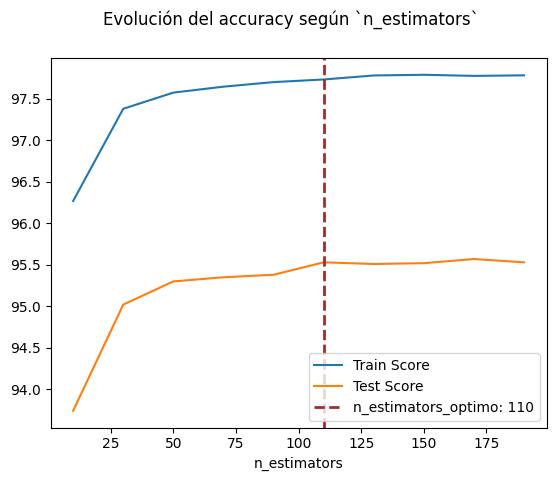

In [171]:
# visualizamos las curvas de score
rs["score_train"].plot(label="Train Score")
rs["score_test"].plot(label="Test Score")
plt.suptitle("Evolución del accuracy según `n_estimators`")
plt.axvline(110, color='brown', linestyle='dashed', linewidth=2, label='n_estimators_optimo: 110')
plt.legend()
plt.show()


Al igual que para el análisis del valor óptimo del parámetro `max_depth`, en el caso del número de arboles (o estimadores) ideal para nuestro modelo `Random Forest`, debemos iterar y en base a un análisis visual encontrar cual es valor que balancea de la mejor manera el accuracy en testing y la distancia entre las performace de la muestra de entrenamiento y testeo.

Para este parametro encontramos un candidato adecuado para el valor 110, es decir nuestro random forest estará compuesto por 110 arboles internos, donde cada uno de ellos tendrá una profundidad máxima de 11 niveles.

## Creación del modelo Random Forest de clasificación óptimo

In [182]:
max_depth = 11
n_estimators = 110
n_jobs = 8

# creamos el modelo optimo
rf_model = RandomForestClassifier(max_depth=max_depth, random_state=0, n_jobs=n_jobs, n_estimators=n_estimators)
rf_model.fit(x_train_r, y_train)

pred_train = rf_model.predict(x_train_r)
pred_test = rf_model.predict(x_test_r)

print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*rf_model.score(x_train_r, y_train)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*rf_model.score(x_test_r, y_test)))

Precisión sobre los datos de entrenamiento: 97.73
Precisión sobre los datos de test: 95.53


Generamos la matriz de confusión para nuestro modelo óptimo

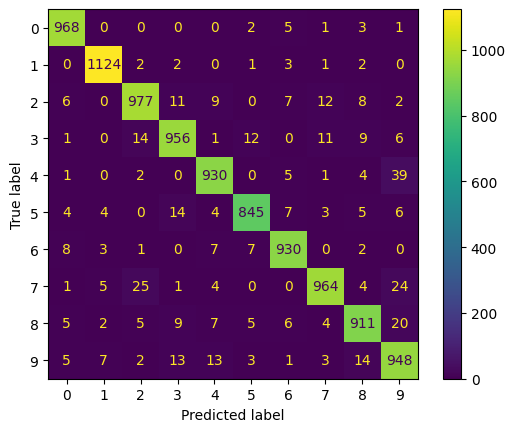

In [183]:
cm = confusion_matrix(y_test, pred_test)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [184]:
print(f"Classification report for classifier {rf_model}:\n"
      f"{classification_report(y_test, pred_test)}\n")

Classification report for classifier RandomForestClassifier(max_depth=11, n_estimators=110, n_jobs=8, random_state=0):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.95      0.95      0.95      1032
           3       0.95      0.95      0.95      1010
           4       0.95      0.95      0.95       982
           5       0.97      0.95      0.96       892
           6       0.96      0.97      0.97       958
           7       0.96      0.94      0.95      1028
           8       0.95      0.94      0.94       974
           9       0.91      0.94      0.92      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.95      0.96     10000
weighted avg       0.96      0.96      0.96     10000




Podemos notar que nuestro modelo tiene un gran desempeño clasificando las imagenes de números que se le presentan, con una precisión del 95% en la etapa de testeo y validación.

A lo largo del práctico pudimos apreciar como afectan a la performance del modelo `Random Forest` cada uno de los parámetros, ya sean propios del modelo como ser `max_depth` o `n_estimators`, o inherentes al particionado de los datos. La busqueda grid resultó ser una gran herramienta a la hora de encontrar el valor óptimo de cada parámetro.